In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/code/code/data/train_ohe_bussub.csv'
test_path  = '/data/ephemeral/home/code/code/data/test_ohe_bussub.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [3]:
import re

# 피처 이름 정리 함수(모델에 들어갔을 때 오류 방지지)
def clean_column_names(columns):
    cleaned_columns = []
    for col in columns:
        # 특수 문자와 공백을 _로 대체
        col = re.sub(r'[^\w\s]', '_', col)  # 특수 문자 제거
        col = re.sub(r'\s+', '_', col)  # 공백을 _로 대체
        col = col.strip('_')  # 앞뒤 언더스코어 제거
        cleaned_columns.append(col)
    return cleaned_columns

# 데이터프레임 열 이름 변환
dt.columns = clean_column_names(dt.columns)
dt_test.columns = clean_column_names(dt_test.columns)
# 확인
print(dt.columns)

Index(['층', '건축년도', '등기신청일자', 'target', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형_생활주택_아파트', '도시형_생활주택_주상복합', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타',
       '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형', '혼합식',
       '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황_60_이하',
       '전용면적별세대현황_60__85_이하', '85__135_이하', '135_초과', '경비비관리형태_기타', '위탁',
       '위탁_직영', '직영_1', '단일계약', '종합계약', '위탁_1', '위탁_직영_1', '직영_2',
       '청소비관리형태_기타', '기타', '의무', '임대_1', '임의', '학군_강남서초', '학군_강동송파', '학군_강서양천',
       '학군_남부', '학군_동부', '학군_동작관악', '학군_북부', '학군_서부', '학군_성동광진', '학군_성북강북',
       '학군_성북광북', '학군_중부', '구_정류장', '구_지하철', '구_강남구', '구_강동구', '구_강북구',
       '구_강서구', '구_관악구', '구_광진구', '구_구로구', '구_금천구', '구_노원구', '구_도봉구', '구_동대문구',
       '구_동작구', '구_마포구', '구_서대문구', '구_서초구', '구_성동구', '구_성북구', '구_송파구', '구_양천구',
       '구_영등포구', '구_용산구', '구_은평구', '구_종로구', '구_중구', '구_중랑구'],
      dtype='object')


In [4]:
# Target과 독립변수들을 분리해줍니다.
# y_train = dt['target']
y = np.log1p(dt['target'])
X = dt.drop(['target'], axis=1)

In [5]:
# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## General XGBoost


In [31]:
# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=10,
    n_estimators=1000,
    use_label_encoder=False,
    eval_metric='rmse',
    random_state=42,  
)

In [32]:
# 모델 학습
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
train_pred = xgb_model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0909


In [34]:
# 예측 및 평가
y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1074


In [24]:
# 학습한 모델을 저장합니다.
import joblib
joblib.dump(xgb_model, './model/xgb_ohe_data_0102_logtarget_1.pkl')

['./model/xgb_ohe_data_0102_logtarget_1.pkl']

In [25]:
# 저장된 모델 정보 불러오기
model = joblib.load("./model/xgb_ohe_data_0102_logtarget_1.pkl")

In [21]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)

CPU times: user 1.41 s, sys: 4.05 ms, total: 1.41 s
Wall time: 184 ms


In [22]:
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

[147243.8  264261.53 300087.47 ...  87260.05  67976.7   72793.14]


In [23]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('./data/submission/output_xgb_ohe_data_0102_logtarget_1.csv', index=False)

## XGBoost Gridsearch

In [17]:
# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(random_state=42)

# XGBoost 하이퍼파라미터 그리드
xgb_param_grid = {
    'n_estimators': [25, 50,75],
    'learning_rate': [0.01, 0.1],
    'max_depth': [10, 25],
}

# XGBoost에 GridSearchCV 적용
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
xgb_grid_search.fit(X_train, y_train)

print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best score for XGBoost:", xgb_grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 75}
Best score for XGBoost: -0.015523781648334066


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 50}

In [18]:
best_model = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_

In [19]:
# 예측 및 평가
y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1181


In [20]:
# 학습한 모델을 저장합니다.
import joblib
# 모델과 하이퍼파라미터를 함께 저장
model_info = {
    "model": best_model,
    "hyperparameters": best_params
}
joblib.dump(model_info, 'xgb_ohe_data_1231_logtarget_2.pkl')

['xgb_ohe_data_1231_logtarget_2.pkl']

In [27]:
# 저장된 모델 정보 불러오기
loaded_info = joblib.load("xgb_ohe_data_1231_logtarget_2.pkl")

# 모델과 하이퍼파라미터 분리
loaded_model = loaded_info["model"]
loaded_params = loaded_info["hyperparameters"]

print("Loaded hyperparameters:", loaded_params)

Loaded hyperparameters: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 75}


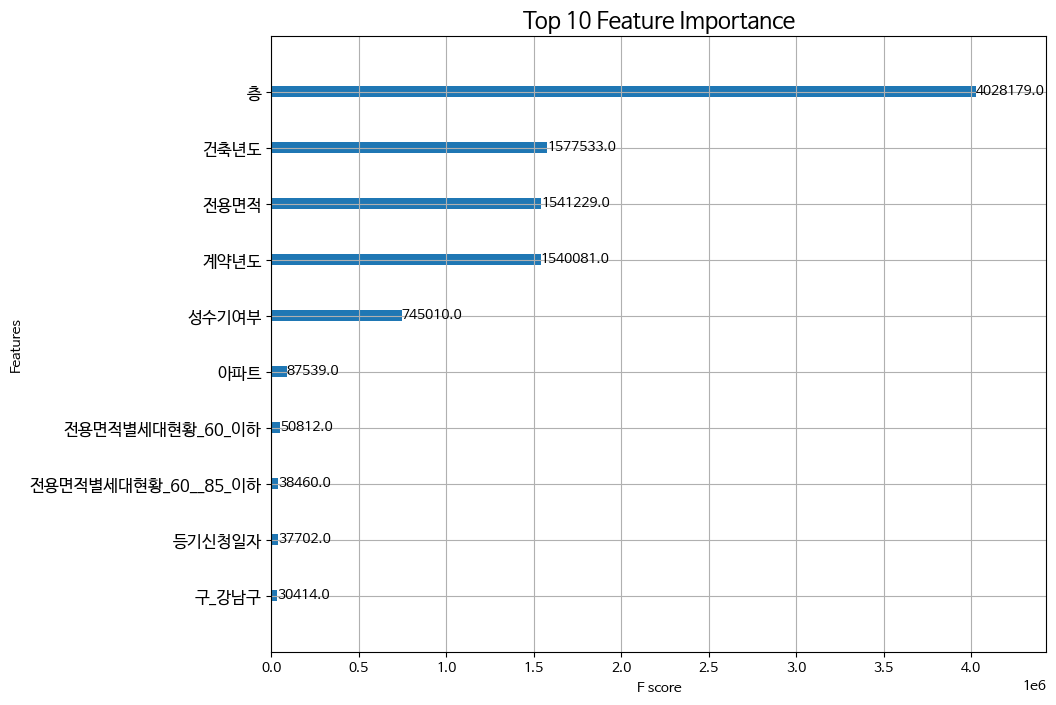

In [32]:
import matplotlib.pyplot as plt
import xgboost as xgb

# 모델에서 feature importance 시각화
fig, ax = plt.subplots(figsize=(10, 8))  # 그래프 크기 조정 (width, height)

# XGBoost plot_importance 함수에서 상위 10개 변수만 표시
xgb.plot_importance(loaded_model, ax=ax, max_num_features=10)

# y축 크기 조정 (font size 조정)
ax.tick_params(axis='y', labelsize=12)  # y축 레이블 크기 조정

# 제목 설정
ax.set_title('Top 10 Feature Importance', fontsize=16)

plt.show()


In [23]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = loaded_model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)

CPU times: user 321 ms, sys: 0 ns, total: 321 ms
Wall time: 51.9 ms


In [24]:
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

[169506.95  245861.34  285992.28  ...  91828.83   70115.82   65393.902]


In [25]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_xgb_ohe_data_1231_logtarget_2.csv', index=False)

In [19]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.feature_importances_, index=X_train.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

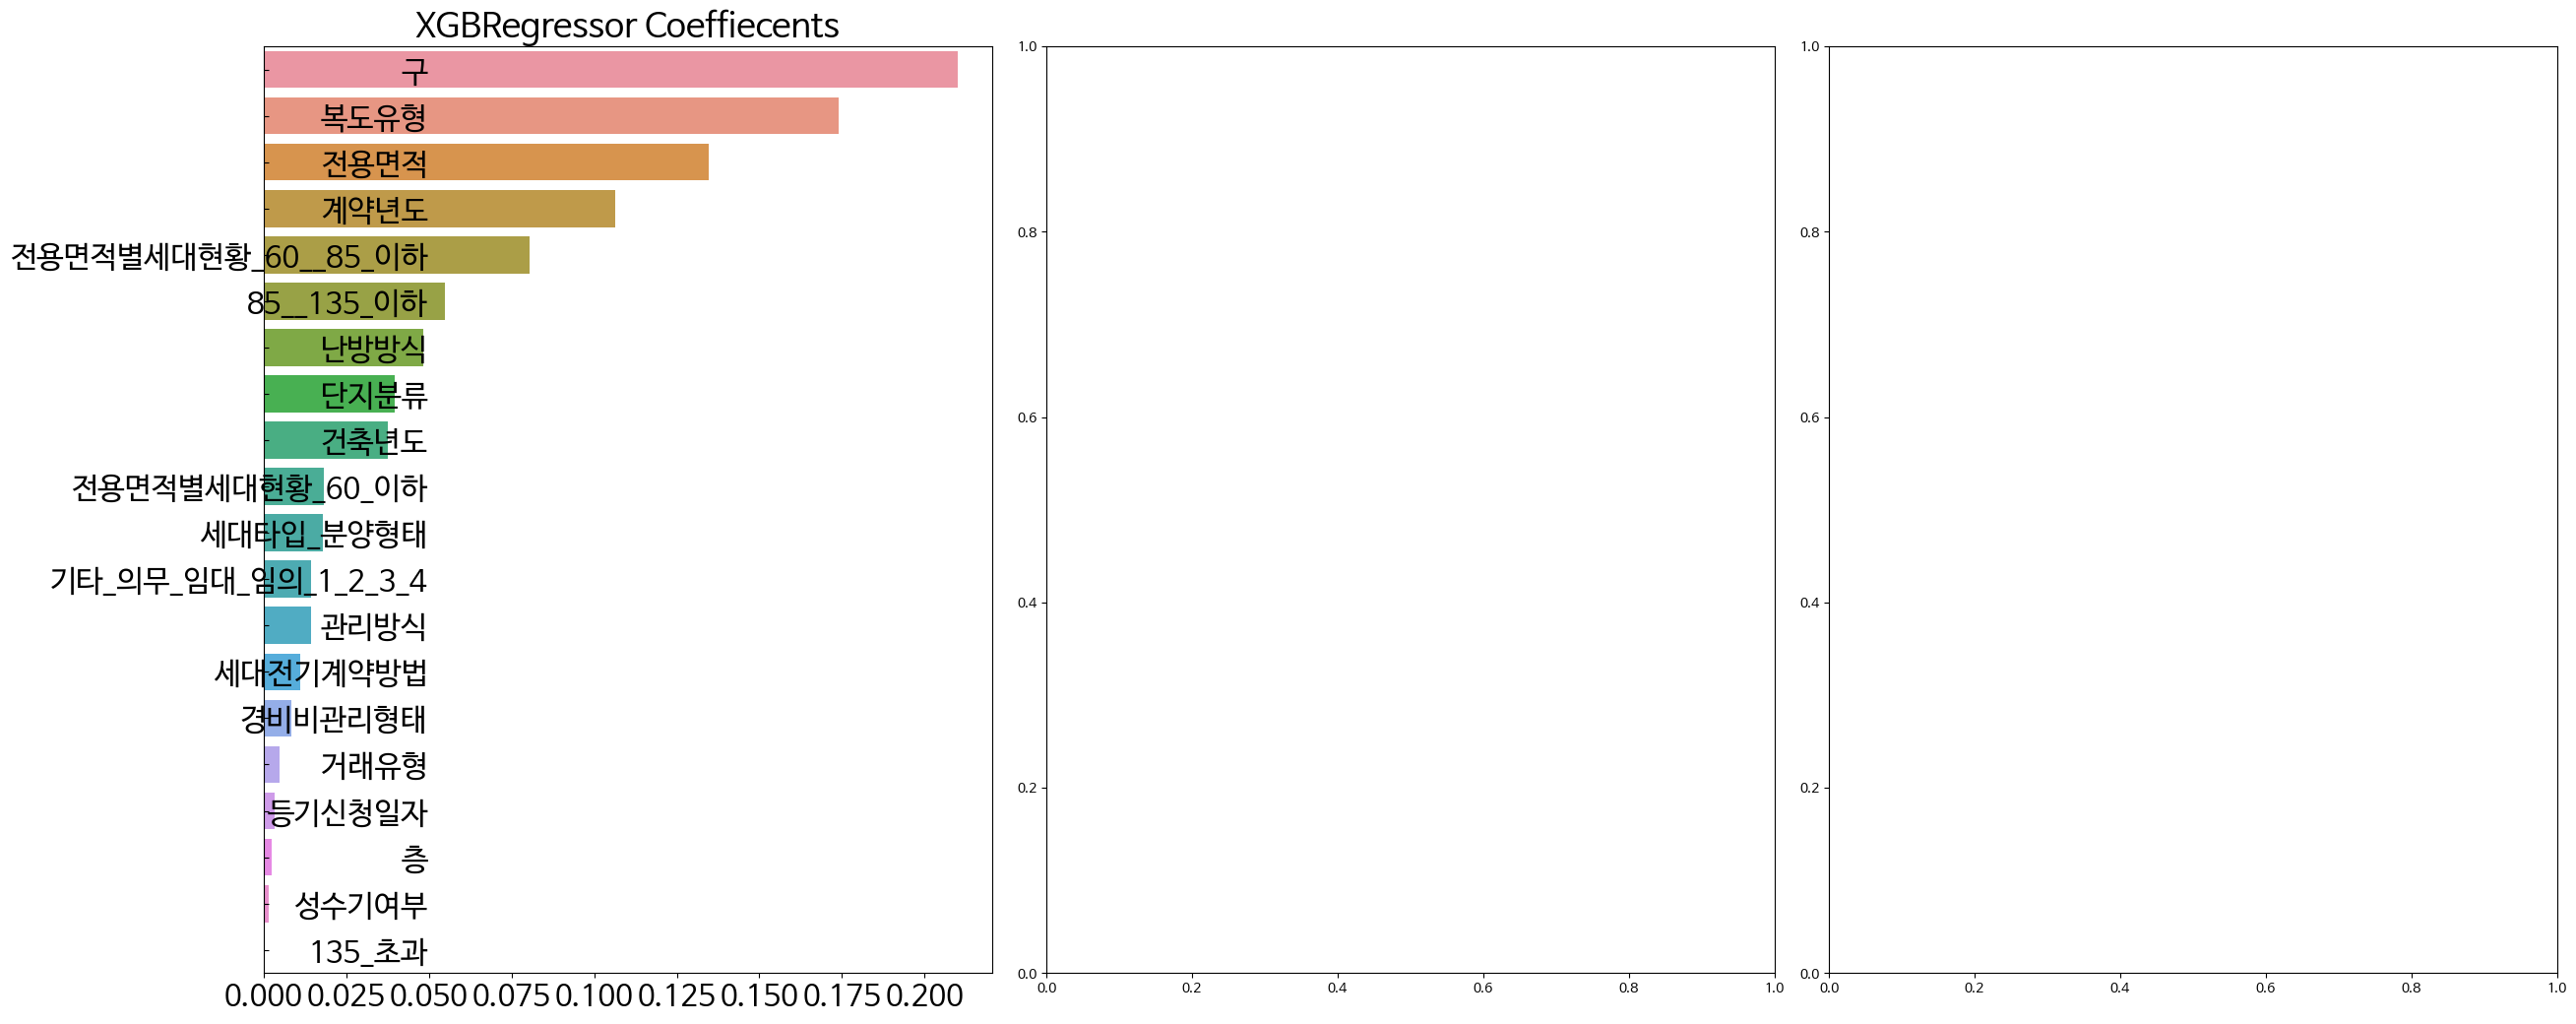

In [20]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [loaded_model]
visualize_coefficient(models)

## General LightGBM

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from lightgbm import early_stopping

In [21]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=10000,        # 트리의 개수
    learning_rate=0.1,       # 학습률
    max_depth=10,             # 트리의 최대 깊이
    num_leaves=1024,          # 리프 노드의 수
    # min_data_in_leaf=20,      # 리프 노드 최소 데이터 수
    random_state=42,           # 랜덤 시드 (결과 재현을 위한 설정)
    metric = 'rmse',
)
lgb_model

LGBMRegressor(max_depth=10, metric='rmse', n_estimators=10000, num_leaves=1024,
              random_state=42)

In [22]:
lgb_model.fit(X_train, y_train, 
              eval_set = [(X_train, y_train),(X_val, y_val)], eval_names=['train', 'valid'],
            callbacks=[early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=1)  # verbose=True 대신 사용
    ])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 84
[LightGBM] [Info] Start training from score 10.751372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's rmse: 0.582728	valid's rmse: 0.583714
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's rmse: 0.534257	valid's rmse: 0.535275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's rmse: 0.49113	valid's rmse: 0.492132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's rmse: 0.45296	valid's rmse: 0.453995
[LightGBM] [Warning] No furthe

LGBMRegressor(max_depth=10, metric='rmse', n_estimators=10000, num_leaves=1024,
              random_state=42)

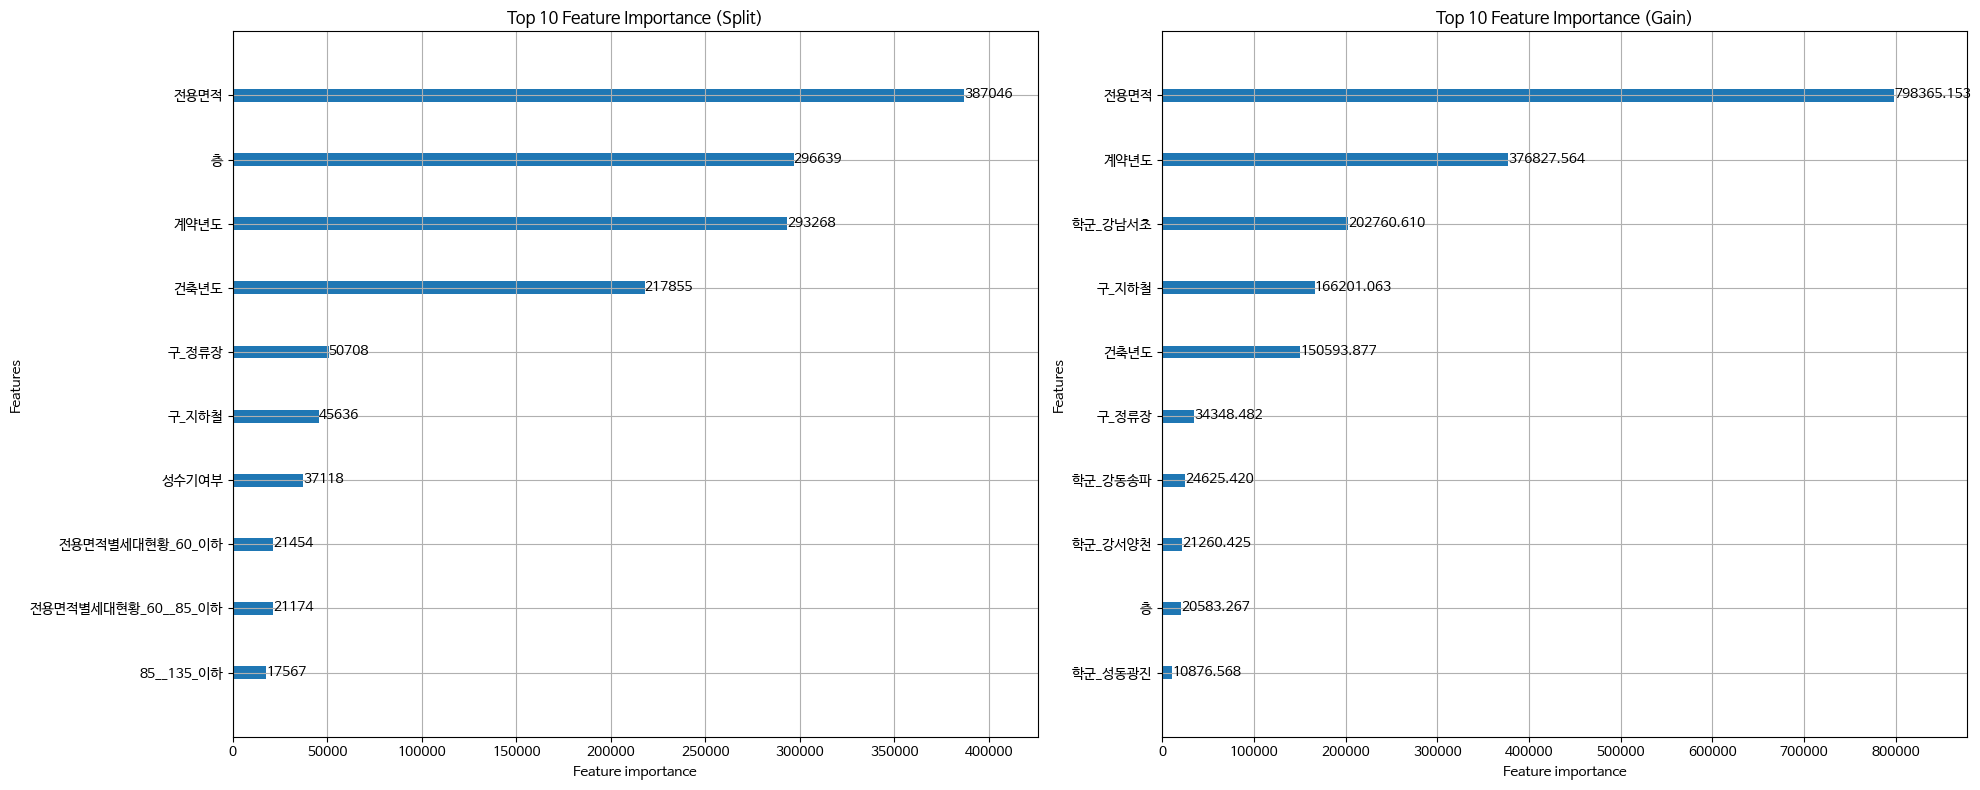

In [30]:
# 전체 그림 크기 설정
plt.figure(figsize=(20, 8))

# Split 기반 상위 10개 Feature importance 플롯
plt.subplot(1, 2, 1)
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=10, ax=plt.gca())
plt.title("Top 10 Feature Importance (Split)")

# Gain 기반 상위 10개 Feature importance 플롯
plt.subplot(1, 2, 2)
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=10, ax=plt.gca())
plt.title("Top 10 Feature Importance (Gain)")

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

In [24]:
# 최종 RMSE 값 가져오기
final_train_rmse = lgb_model.evals_result_['train']['rmse'][-1]
final_valid_rmse = lgb_model.evals_result_['valid']['rmse'][-1]
print(final_valid_rmse - final_train_rmse)

0.024681164878776723


In [25]:
y_pred = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0997


In [26]:
# 학습한 모델을 저장합니다.
import joblib
# 모델과 하이퍼파라미터를 함께 저장
joblib.dump(lgb_model,'./model/lgb_ohe_data_0103_logtarget_2.pkl')

['./model/lgb_ohe_data_0103_logtarget_2.pkl']

In [27]:
# 저장된 모델 정보 불러오기
loaded_model = joblib.load("./model/lgb_ohe_data_0103_logtarget_2.pkl")
print(loaded_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10000, 'n_jobs': None, 'num_leaves': 1024, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse'}


In [28]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = loaded_model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

[173050.49086881 266846.23455144 328280.09091081 ...  90432.8718294
  69359.19582806  67521.86139378]
CPU times: user 32.4 s, sys: 3.95 ms, total: 32.4 s
Wall time: 3.36 s


In [29]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('./data/submission/output_lgb_ohe_data_0103_logtarget_2.csv', index=False)

## K Fold LightGBM


In [8]:
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from lightgbm import early_stopping

# KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lgb_preds = []  # LightGBM 예측값
xgb_preds = []  # XGBoost 예측값
fold_rmse_scores = []  # 각 Fold의 RMSE 점수 저장

# KFold 교차 검증
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold} 시작")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # LightGBM 모델
    lgb_model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=10,
        num_leaves=1024,
        random_state=42
    )
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
    )
    lgb_fold_pred = lgb_model.predict(X_val)
    lgb_preds.append(lgb_fold_pred)
    
    # XGBoost 모델
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        tree_method='hist',
        eval_metric='rmse',
        early_stopping_rounds=50  # 여기에 early_stopping_rounds를 추가
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
    )

    xgb_fold_pred = xgb_model.predict(X_val)
    xgb_preds.append(xgb_fold_pred)
    
    # 앙상블 예측 및 RMSE 계산
    fold_ensemble_pred = (lgb_fold_pred + xgb_fold_pred) / 2
    fold_rmse = np.sqrt(mean_squared_error(y_val, fold_ensemble_pred))
    fold_rmse_scores.append(fold_rmse)
    
    print(f"Fold {fold} RMSE: {fold_rmse:.4f}")
    print(f"Fold {fold} 완료\n")

Fold 1 시작
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 84
[LightGBM] [Info] Start training from score 10.751372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [9]:
# 예측값 앙상블
lgb_preds = np.concatenate(lgb_preds, axis=0)
xgb_preds = np.concatenate(xgb_preds, axis=0)
ensemble_preds = (lgb_preds + xgb_preds) / 2

In [12]:
print(lgb_preds)

[11.55995485 11.31937867 11.73855282 ... 10.16152191 10.46024428
  9.78572145]


In [13]:
print(xgb_preds)

[11.592287 11.303637 11.775984 ... 10.175706 10.47867   9.796974]


In [10]:
# 최종 결과 평가
final_rmse = np.sqrt(mean_squared_error(y, ensemble_preds))
print(f"\nFinal Ensemble RMSE: {final_rmse:.4f}")


Final Ensemble RMSE: 0.8648


In [11]:
# 각 Fold의 RMSE 출력
print("\nFold-wise RMSE Scores:")
for fold, score in enumerate(fold_rmse_scores, 1):
    print(f"Fold {fold}: {score:.4f}")


Fold-wise RMSE Scores:
Fold 1: 0.1059
Fold 2: 0.1062
Fold 3: 0.1068
Fold 4: 0.1057
Fold 5: 0.1048


In [ ]:
y_pred = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

In [ ]:
# 학습한 모델을 저장합니다.
import joblib
# 모델과 하이퍼파라미터를 함께 저장
joblib.dump(lgb_model,'./model/lgb_ohe_data_0102_logtarget_1.pkl')

In [ ]:
# 저장된 모델 정보 불러오기
loaded_model = joblib.load("./model/lgb_ohe_data_0102_logtarget_1.pkl")

In [ ]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = loaded_model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('./data/submission/output_lgb_ohe_data_0102_logtarget_1.csv', index=False)

## LightGBM Gridsearch

In [120]:
# LightGBM 모델 생성
lgb_model = lgb.LGBMRegressor(random_state=42)

# LightGBM 하이퍼파라미터 그리드
lgb_param_grid = {
    'n_estimators': [1000, 1100],
    'learning_rate': [0.1],
    'max_depth': [10,],
    'num_leaves': [1024, 1200],
}

# LightGBM에 GridSearchCV 적용
lgb_grid_search = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
lgb_grid_search.fit(X_train, y_train)

print("Best parameters for LightGBM:", lgb_grid_search.best_params_)
print("Best score for LightGBM:", lgb_grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 596704, number of used features: 84
[LightGBM] [Info] Start training from score 10.750462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [121]:
best_model = lgb_grid_search.best_estimator_
best_params = lgb_grid_search.best_params_
print(best_model, best_params)

LGBMRegressor(max_depth=10, n_estimators=1100, num_leaves=1024, random_state=42) {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1100, 'num_leaves': 1024}


In [122]:
# 예측 및 평가
y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1073


In [22]:
# 학습한 모델을 저장합니다.
import joblib
# 모델과 하이퍼파라미터를 함께 저장
model_info = {
    "model": best_model,
    "hyperparameters": best_params
}
joblib.dump(model_info, './model/lgb_ohe_data_0101_logtarget_2.pkl')

['./model/lgb_ohe_data_0101_logtarget_2.pkl']

In [23]:
# 저장된 모델 정보 불러오기
loaded_info = joblib.load("./model/lgb_ohe_data_0101_logtarget_2.pkl")

# 모델과 하이퍼파라미터 분리
loaded_model = loaded_info["model"]
loaded_params = loaded_info["hyperparameters"]
print("Loaded hyperparameters:", loaded_params)

Loaded hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'num_leaves': 1024}


In [24]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = loaded_model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

[157074.28810036 258017.35841473 316404.71240025 ...  88207.860482
  69491.67986587  66722.26068305]
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 150 ms


In [25]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('./data/submission/output_lgb_ohe_data_0101_logtarget_2.csv', index=False)